# Supervisely Tutorial #4

# Neural networks: deploy and inference with Supervisely online API

In this tutorial we will show how to deploy a neural network model for online inference and perform inference requests using Supervisely online API from our SDK.

## Setup steps

Before we can start issuing inference requests, we need to connect to the Supervisely web instance, make sure the model we need is available and set up a worker machine to load the model on.

### Necessary imports

Simply import the Supervisrly Python SDK module:

In [24]:
import supervisely_lib as sly

Just for illustrations in this tutorial, a helper to render labeled objects on images:

In [25]:
# PyPlot for drawing images in Jupyter.
%matplotlib inline
import matplotlib.pyplot as plt

def draw_labeled_image(img, ann):
    canvas_draw_contour = img.copy()
    ann.draw_contour(canvas_draw_contour, thickness=7)
    fig = plt.figure(figsize=(30, 30))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    fig.add_subplot(1, 2, 2)
    plt.imshow(canvas_draw_contour)    
    plt.show() 

### Initialize API access with your credentials

Before starting to interact with a Supervisely web instance using our API, you need to supply your use credentials: your unique access token that you can find under your profile details:

In [26]:
import os

# Jupyter notebooks hosted on Supervisely can get their user's
# credentials from the environment varibales.
# If you are running the notebook outside of Supervisely, plug
# the server address and your API token here.
# You can find your API token in the account settings:
# -> click your name in the top-right corner
# -> select "account settings"
# -> select "API token" tab on top.
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

print("Server address: ", address)
print("Your API token: ", token)

# Initialize the API access object.
api = sly.Api(address, token)

Server address:  192.168.1.69:5555
Your API token:  HfQ2owV8QjwojwnTiaPzIyEZtncIBjISnQqgBzKmDTjTL6WmV80kbd9J5DHu8PnCPVBqWBUXcOQlqjUBiCrQuUBxh562iaqAzqa4z80lJYjvxTFky5RbHDXregjOf2y8


### Define the active workspace

In Supervisely, every neural network model (and also every data project) is stored in a context of a certain *workspace*. See our tutorial #2 for a detailed guide on how to work with workspaces using our online API.

Here we will create a new workspace to avoid interfering with any existing work.

In [27]:
# In Supervisely, a user can belong to multiple teams.
# Everyone has a default team with just their user in it.
# We will work in the context of that default team.
team = api.team.get_list()[0]

# Set up the name of a new workspace to be created.
workspace_name = "api_inference_tutorial"

# Just in case there is already a workspace with this name,
# we can ask the web instance for a new unique name to use.
if api.workspace.exists(team.id, workspace_name):
    workspace = api.workspace.get_info_by_name(team.id, workspace_name)
else:
    workspace = api.workspace.create(team.id, workspace_name)

# Print out the results.
# Here we will see which name our workspace ended up with.
print("Team: id={}, name={}".format(team.id, team.name))
print("Workspace: id={}, name={}".format(workspace.id, workspace.name))

Team: id=4, name=max
Workspace: id=69, name=api_inference_tutorial


### Add the neural network model to the workspace

Now that we have an empty workspace, we need to add a neural network model to it. Here we will clone one of the existing publically avaliable in Supervisely models.

In [28]:
# Set the destination model name within our workspace
model_name = "yolo_coco"

# Grab a unique name in case the one we chose initially is busy.
if api.model.exists(workspace.id, model_name):
    model_name = api.model.get_free_name(workspace.id, model_name)

# Request the model to be copied from our public repository.
# This kicks off an asynchronous task.
task_id = api.model.clone_from_explore('Supervisely/Model Zoo/YOLO v3 (COCO)', workspace.id, model_name)

# Wait for the copying to complete.
api.task.wait(task_id, api.task.Status.FINISHED)

# Query the metadata for the copied model.
model = api.model.get_info_by_name(workspace.id, model_name)
print("Model: id = {}, name = {!r}".format(model.id, model.name))

Model: id = 148, name = 'yolo_coco_001'


### Select the agent to use

Neural network inference is a computationally intensive process, so it is infeasible to have the inference run on the same machine that serves the Supervisely web instance. Instead, you need to connect a worker machine (with a GPU) to the web instance to run the computations. The worker is connected using the *Supervisely Agent* - an open-source daemon that runs on the worker, connects to the web instance and listens for tasks to execute. See https://github.com/supervisely/agent for details on how to run the agent.

From now on the tutorial assumes that you have launched the agent on your worker machine and it shows up on your "Cluster" page in the Supervisely web instance. We first query the instance for the agent ID by name.

In [29]:
# Replace this with your agent name. You can find the list of
# all your agents in the "Cluster" menu in the Supervisely instance.
agent_name = "agent_01"

agent = api.agent.get_info_by_name(team.id, agent_name)
if agent is None:
    raise RuntimeError("Agent {!r} not found".format(agent_name))
if agent.status is api.agent.Status.WAITING:
    raise RuntimeError("Agent {!r} is not running".format(agent_name))

## Online on-demand inference

We have all the pre-requisites in place, time to get started with model inference.

### Deploy the model to the agent for on-demand inference

The first step is to deploy the model to the agent. Deployment involves:
* copying the model weights and configuration to the agent,
* launching a Docker container with the model code that loads the weights onto the worker GPU and starts waiting for inference requests.

In [30]:
# Just in case that the model has been already deployed
# (maybe you are re-running some of this tutorial several times)
# we want to reuse the already deployed version.
#
# Query the web instance for already deployed instances of our model.
task_ids = api.model.get_deploy_tasks(model.id)

# Deploy if necessary.
if len(task_ids) == 0:
    print('Model {!r} is not deployed. Deploying...'.format(model.name))
    task_id = api.task.deploy_model(agent.id, model.id)
    # deploy_model() kicks off an asynchronous task that may take
    # quite a long time - after all, the agent on the worker needs to
    # * Download the model weights from web instance.
    # * Pull the docker image with the model code.
    # * Launch a docker image and wait for it to load the weights onto the GPU.
    #
    # Since we don't have other tasks to process, simply wait
    # for deployment to finish.
    api.task.wait(task_id, api.task.Status.DEPLOYED)
else:
    print('Model {!r} has been already deployed'.format(model.name))
    task_id = task_ids[0]

print('Deploy task_id = {}'.format(task_id))

Model 'yolo_coco_001' is not deployed. Deploying...
Deploy task_id = 1168


### Get the metadata for the deployed model

Every neural network model is trained to predict a specific set of classes. This set of classes is stored in the model config, and the code loading the mode also parses that config file.

Once the model has been deployed, we can ask it for the set of classes it can predict. The result is a serialized metadata, which can be conveniently parsed into a ProjectMeta object from our Python SDK. See our tutorial #1 for a detailed guide on how to work with metadata using the SDK.

In [31]:
meta_json = api.model.get_output_meta(model.id)
model_meta = sly.ProjectMeta.from_json(meta_json)
print(model_meta)

ProjectMeta:
Object Classes
+----------------------+-----------+-----------------+
|         Name         |   Shape   |      Color      |
+----------------------+-----------+-----------------+
|     person_model     | Rectangle | [146, 208, 134] |
|    bicycle_model     | Rectangle | [116, 127, 233] |
|      car_model       | Rectangle | [233, 189, 207] |
|   motorbike_model    | Rectangle | [111, 190, 245] |
|   aeroplane_model    | Rectangle |  [92, 126, 104] |
|      bus_model       | Rectangle | [212, 239, 134] |
|     train_model      | Rectangle | [140, 180, 183] |
|     truck_model      | Rectangle | [231, 222, 180] |
|      boat_model      | Rectangle |  [213, 86, 211] |
| traffic light_model  | Rectangle | [137, 206, 104] |
|  fire hydrant_model  | Rectangle | [194, 160, 183] |
|   stop sign_model    | Rectangle | [131, 156, 191] |
| parking meter_model  | Rectangle |  [96, 163, 96]  |
|     bench_model      | Rectangle | [232, 202, 225] |
|      bird_model      | Rectangle | 

### Inference with a locally stored image

We can finally start with inference requests. First example shows how to deal with an image loaded into local memory as a Numpy array. The inference result is a serialized image `Annotation`, another fundamental class from our SDK that stores image labeling data. See our tutorial #1 for a detailed look at image annotations.

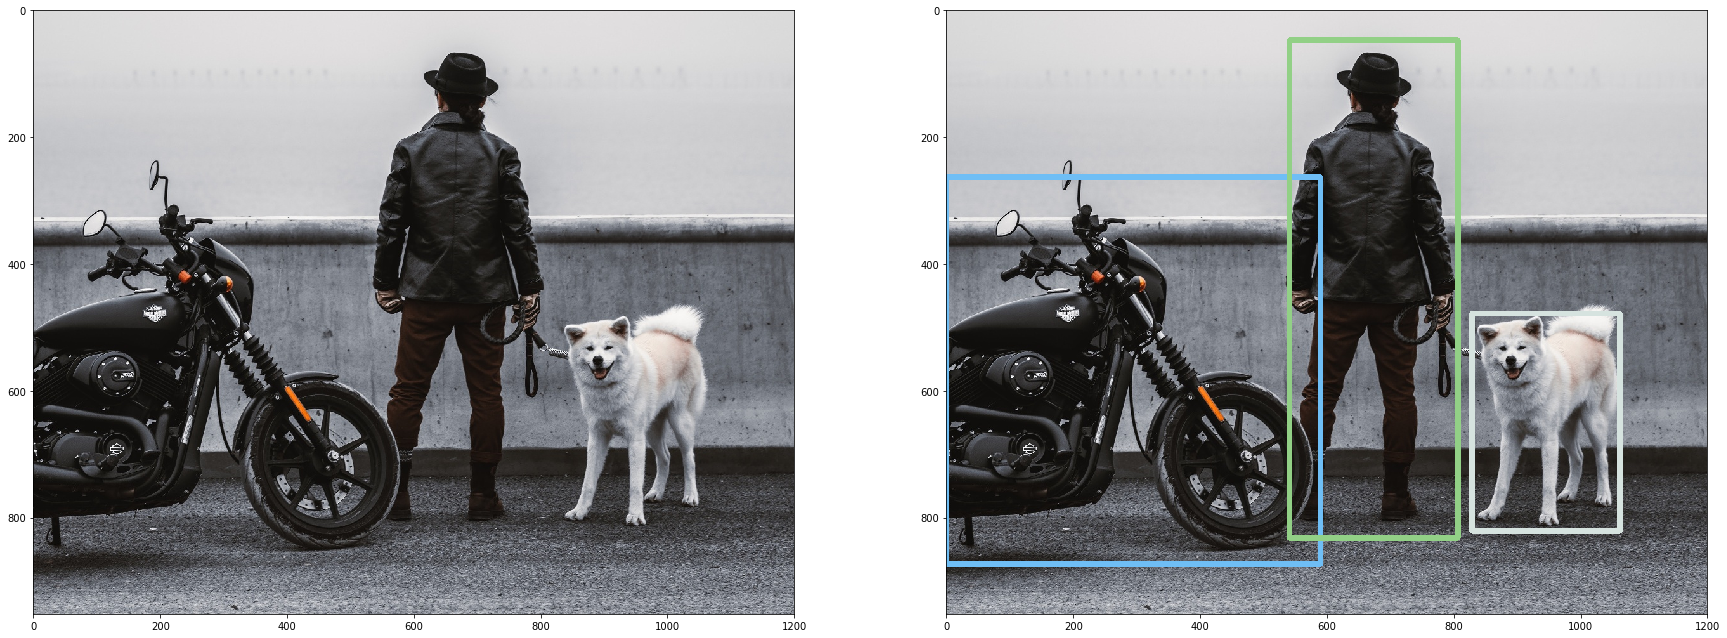

In [32]:
img = sly.image.read('./image_01.jpeg')

# Make an inference request, get a JSON serialized image annotation.
ann_json = api.model.inference(model.id, img)

# Deserialize the annotation using the model meta information that
# we received previously.
ann = sly.Annotation.from_json(ann_json, model_meta)

# Render the inference results.
draw_labeled_image(img, ann)

### Inference with an external image via web link 

Often one has images located remotely, accessible via HTTP. In this case it is straightforward with out SDK to prepare raw image data for the inference request:

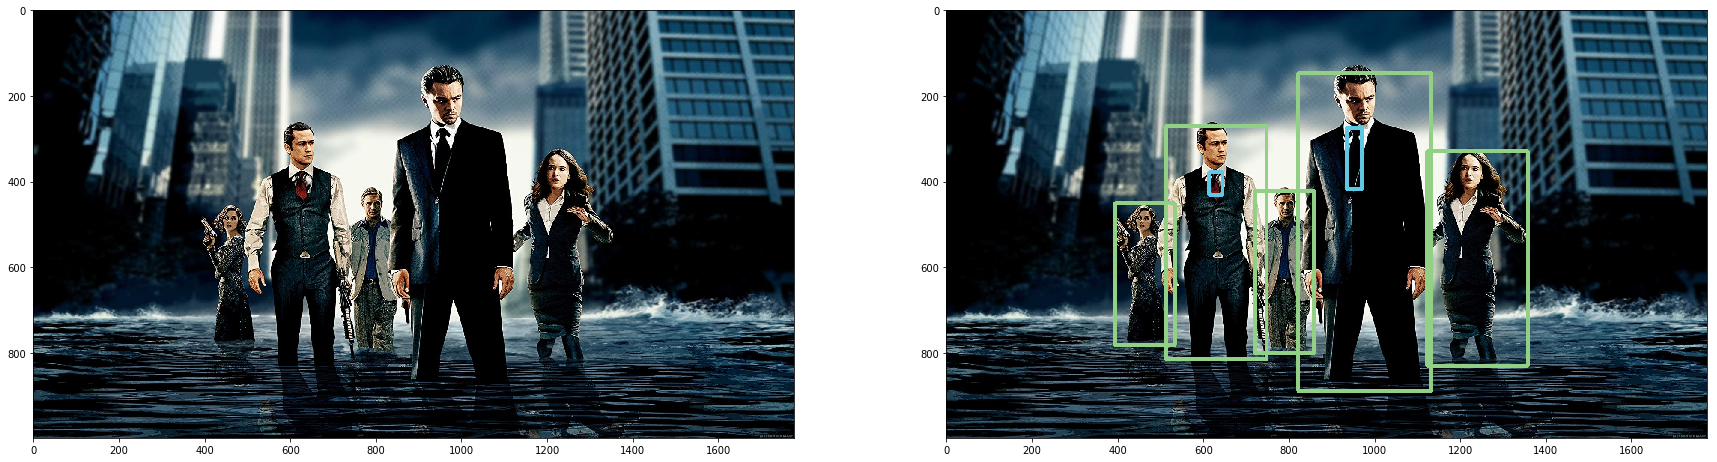

In [33]:
import numpy as np
import requests      # For reading data over HTTP.

image_url = "https://m.media-amazon.com/images/M/MV5BOTQ0OWRjYzAtNGIzZC00MzFkLWI1MjAtYTU0ZDNlMjIyMjU4XkEyXkFqcGdeQXVyNTc3MjUzNTI@._V1_SX1777_CR0,0,1777,999_AL_.jpg"
response = requests.get(image_url)
# Wrap the raw encoded image bytes.
# Decode the JPEG data. Make sure to use our decoding wrapper to
# guarantee the right number and order of color channel.
img = sly.image.read_bytes(response.content)

# Make an inference request, get a JSON serialized image annotation.
ann_json = api.model.inference(model.id, img)
# Deserialize the annotation.
ann = sly.Annotation.from_json(ann_json, model_meta)
# Render results.
draw_labeled_image(img, ann)

### Inference with images from Supervisely projects

Another frequent scenario is to run inference on images that have been already uploaded to the Supervisely web instance. In this case we have a special API to avoid re-downloading and uploading the image back to the web instance. Instead, one would simply pass the Supervisely image ID to the inference request.

#### Set up the input project

Let us set up an example input project from which we will feed images for inference to the deployed model. We will clone one of the publically available in Supervisely projects.

In [34]:
src_project_name = "persons_src"

# Grab a free project name if ours is taken.
if api.project.exists(workspace.id, src_project_name):
    src_project_name = api.project.get_free_name(workspace.id, src_project_name)

# Kick off the a project clone task and wait for completion.
task_id = api.project.clone_from_explore('Supervisely/Demo/persons', workspace.id, src_project_name)
api.task.wait(task_id, api.task.Status.FINISHED)

src_project = api.project.get_info_by_name(workspace.id, src_project_name)
print("Project: id = {}, name = {!r}".format(src_project.id, src_project.name))

Project: id = 567, name = 'persons_src_001'


#### Set up the output project

Next, create a destination project to hold the inference results:

In [35]:
dst_project_name = "persons_inf_yolo"

if api.project.exists(workspace.id, dst_project_name):
    dst_project_name = api.project.get_free_name(workspace.id, dst_project_name)
    
dst_project = api.project.create(workspace.id, dst_project_name, description="after inference")
print("Destination Project: id={}, name={!r}".format(dst_project.id, dst_project.name))

Destination Project: id=568, name='persons_inf_yolo_001'


We also need to tell the web instance which classes the projects will hold. We already know which classes the model predicts from its meta information, so just use that set of classes in the destination project:

In [36]:
api.project.update_meta(dst_project.id, model_meta.to_json())

#### Run inference over input project

Input and outputs projects are all set, now we can loop over the input images, make inference requests and write out the results to the output project:

In [37]:
# Pretty-printing text progress bars.
from tqdm import tqdm

# Go over all the datasets in the input project.
for dataset in api.dataset.get_list(src_project.id):
    print("Dataset: {!r}".format(dataset.name))
    
    # Create a corresponding dataset in the output project.
    dst_dataset = api.dataset.create(dst_project.id, dataset.name)
    
    # Go over all images in the dataset.
    for image in tqdm(api.image.get_list(dataset.id)):
        # Add the raw image to the output dataset by meta information.
        # Notice that we do not download the actual image here, only
        # the metadata. It is sufficient for Supervisely web instance
        # to locate the correct image in its storage.
        dst_image = api.image.upload_id(dst_dataset.id, image.name, image.id)
        
        # Inference request also using only image meta information.
        ann_json = api.model.inference_remote_image(model.id, dst_image.hash)
        
        # Deserialize the resulting annotation JSON data to make sure it
        # is consistent with the model output meta.
        ann = sly.Annotation.from_json(ann_json, model_meta)
        
        # Upload the annotation to the Supervisely web instance and
        # attach it to the proper image in the output dataset.
        api.annotation.upload_json(dst_image.id, ann.to_json())

  0%|          | 0/5 [00:00<?, ?it/s]

Dataset: 'ds1'


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


## Stop the deployed model

We are done with the tutorial. Before we quit, however, we need to take down the deployed model so that it does not spin forever on our worker machine, wasting resources.

Model can be stopped using web UI or API. For web UI, please go to the web UI (Clusters menu on the left, then Tasks tab on top) and press "stop task" button manually.

In [38]:
deploy_task_id = api.model.get_deploy_tasks(model.id)[0]
print(deploy_task_id)

1168


In [39]:
api.task.get_status(deploy_task_id)

<Status.DEPLOYED: 'deployed'>

In [40]:
api.task.stop(deploy_task_id)
api.task.wait(deploy_task_id, api.task.Status.STOPPED)
print('task {} has been successfully stopped'.format(deploy_task_id))
print(api.task.get_status(deploy_task_id))

task 1168 has been successfully stopped
Status.STOPPED
